# Simple Tv Series multi-label Clasification Using ClassifierChain ######
___


###### Librerias de manejo y exploracion de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###### Librerias para Text Mining

In [2]:
import string 
import re
from nltk.corpus import stopwords # para excluir palabras 
from nltk.stem.wordnet import WordNetLemmatizer # lematizar : para transformar las palabra a un estadod mjor
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords

#### Library para model training

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [4]:
datos = pd.read_csv('../datos/tablas_series_tv.csv',sep=";").drop('Unnamed: 0',axis=1)

## Exploración de Datos
***

In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
Titulo      4800 non-null object
Sinopsis    4162 non-null object
Genero      4800 non-null object
dtypes: object(3)
memory usage: 112.6+ KB


In [6]:
datos.head()

,Titulo,Sinopsis,Genero
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial"
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación"
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense"
4,10,NaN,Drama


In [7]:
datos = datos.dropna().reset_index(drop=True)
datos.head()

,Titulo,Sinopsis,Genero
0,#Cartel,#Cartel es una serie dramática de televisión d...,"Suspense,Judicial"
1,'Allo 'Allo,La vida es cualquier cosa menos simple para Re...,Comedia
2,(Des)encanto,(Des)encanto es una comedia de animación para ...,"Fantasía,Animación"
3,+ De 100 Mentiras,+ De 100 Mentiras narra la historia de un hack...,"Drama,Suspense"
4,10 Razones para odiarte,"En el colegio Padua High, las hermanas Kat y B...",Comedia


###### Genero : construccion de target
Se observa que apartir de romantico es significativo la frecuencia

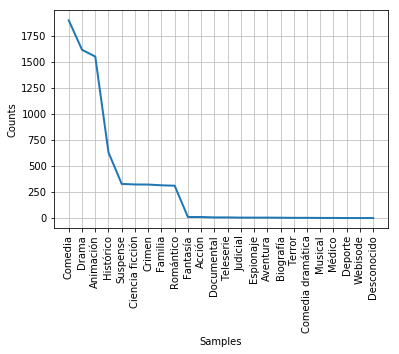

FreqDist({'Comedia': 1896, 'Drama': 1614, 'Animación': 1549, 'Histórico': 630, 'Suspense': 328, 'Ciencia ficción': 323, 'Crimen': 322, 'Familia': 315, 'Romántico': 311, 'Fantasía': 11, ...})

In [8]:
c = [i.split(',') for i in datos.Genero]
generos = [i for j in c for i in j]
frec_genro = FreqDist(generos)
frec_genro.plot()
frec_genro

Nos quedamos con los generos que tienen una presencia siginificativa

In [9]:
Genro = np.array(['Comedia','Drama', 'Animación', 'Histórico','Suspense','Ciencia ficción','Crimen','Familia','Romántico'])

Construimos dummies

In [10]:
Genro_dummies = pd.DataFrame(np.zeros((datos.shape[0],len(Genro))),columns=Genro)
Genro_dummies.head()

,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
for i in Genro :
    Genro_dummies[i]= np.int0(datos.Genero.str.find(i)>=0)
Genro_dummies.head()

,Comedia,Drama,Animación,Histórico,Suspense,Ciencia ficción,Crimen,Familia,Romántico
0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0


Se excluye aquellos que no tienen ningun genero

In [12]:
filt_casos = Genro_dummies.apply(sum,axis=1)>0
Genro_dummies = Genro_dummies[filt_casos]

Grafica de casos multi_etiqueta

In [13]:
a = Genro_dummies.apply(lambda x : ','.join(x.astype(str)),axis=1)
b = pd.crosstab(a,True)
c = list(b.index.str.split(','))
d = [[bool(int(i)) for i in d] for d in c]

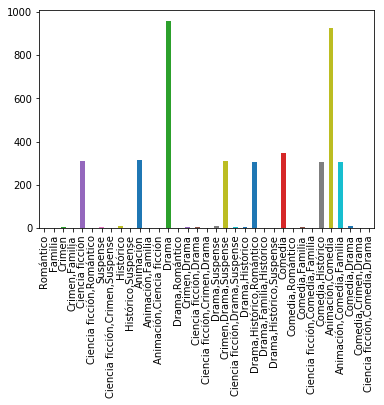

In [14]:
res_gnero = pd.Series(b.values.reshape(b.values.shape[0]),index=[','.join(np.unique(Genro[i])) for i in d])
res_gnero.plot.bar()

##### Nuevo Data Frame con casos excluidos 

In [15]:
datos_new = pd.concat([datos[filt_casos],Genro_dummies],axis=1)

In [16]:
datos_new.shape,datos.shape

((4151, 12), (4162, 3))

###### Sinopsis : limpieza, transformación y preparacion de textos

In [17]:
stop = stopwords.words('spanish')

In [18]:
stop.extend(['Comedia', 'Drama', 'Animación', 'Histórico', 'Suspense', 'Crimen','Ciencia ficción',
       'Familia', 'Romántico'])
exclude = set(string.punctuation) 

In [19]:
# Lemmatizacion de las palabras 
lemma = WordNetLemmatizer() 
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized2 = " ".join(list(set([i for i in normalized.split() if i not in stop])))
    return normalized2

Sin limpieza de texto

In [20]:
plt.figure(figsize=(200,200))
wordcloud = WordCloud(
            background_color ='white',
            min_font_size = 10,max_words=20).generate(' '.join(datos.Sinopsis))
plt.imshow(wordcloud)

Con limpieza de Texto

In [21]:
datos_new['Sinopsis']=[clean(i) for i in datos_new.Sinopsis]

In [22]:
plt.figure(figsize=(200,200))
wordcloud = WordCloud(
            background_color ='white',
            min_font_size = 5,max_words=100).generate(' '.join(datos_new.Sinopsis))
plt.imshow(wordcloud)

#### Preparacion para training

In [23]:
# El metodo CountVectorizer de sklearn hace todo el preprocesamiento junto, stopwords, lowercase;tokenizacion usando regex
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words=stop, lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
X= vectorizer.fit_transform(datos_new.Sinopsis)

y = Genro_dummies


#### Training model

In [24]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
classifier = ClassifierChain(DecisionTreeClassifier())
classifier.fit(Xtrain, ytrain)

ClassifierChain(classifier=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
        order=None, require_dense=[True, True])

In [26]:
predictions = classifier.predict(Xtest)

In [27]:
Genro

array(['Comedia', 'Drama', 'Animación', 'Histórico', 'Suspense',
       'Ciencia ficción', 'Crimen', 'Familia', 'Romántico'], dtype='<U15')

In [28]:
print(classification_report(ytest,predictions,
                            target_names=Genro))

                 precision    recall  f1-score   support

        Comedia       0.99      0.98      0.99       651
          Drama       0.97      0.97      0.97       513
      Animación       1.00      1.00      1.00       506
      Histórico       0.96      0.98      0.97       203
       Suspense       0.92      0.91      0.92       104
Ciencia ficción       0.96      0.97      0.96       115
         Crimen       0.95      0.98      0.96        98
        Familia       0.99      0.97      0.98       109
      Romántico       0.98      0.99      0.98        95

    avg / total       0.98      0.98      0.98      2394

